# MSAS SOH@EFC600: Model Comparison (Ridge / XGBoost / RandomForest)

This notebook compares three models on the MSAS EFC-aligned feature setup.
It trains each model and reports test RMSE/MAE.

Prereqs:
- `data/processed/MSAS` exists (run MSAS preprocessing first).
- `batteryml` is importable.
- `xgboost` is installed for the XGBoost model.


In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import batteryml
from batteryml.pipeline import Pipeline

In [2]:
try:
    import xgboost  # noqa: F401
except ImportError as exc:
    raise ImportError("xgboost is required for the XGBoost model. Install it first.") from exc

In [3]:
def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "batteryml").exists() and (p / "configs").exists():
            return p
    return start

env_root = os.environ.get("BATTERYML_REPO_ROOT")
if env_root:
    repo_root = Path(env_root)
else:
    repo_root = find_repo_root(Path.cwd())
    if not (repo_root / "configs").exists():
        pkg_root = Path(batteryml.__file__).resolve().parents[1]
        repo_root = find_repo_root(pkg_root)

os.chdir(repo_root)
data_root = repo_root / "data/processed/MSAS"
if not data_root.exists():
    raise FileNotFoundError(
        f"MSAS processed data not found: {data_root}. Run preprocessing first."
    )

config_map = {
    "Ridge": "configs/soh/transfer/msas_soh_efc600_efcnorm_ridge.yaml",
    "XGBoost": "configs/soh/transfer/msas_soh_efc600_efcnorm_xgb.yaml",
    "RandomForest": "configs/soh/transfer/msas_soh_efc600_efcnorm_rf.yaml",
}

force_rerun = True  # set False to reuse existing checkpoints
results = []

for name, rel_path in config_map.items():
    config_path = repo_root / rel_path
    if not config_path.exists():
        raise FileNotFoundError(f"Missing config: {config_path}")
    workspace = repo_root / f"workspaces/msas/soh_efc600_compare/{name.lower()}"
    pipe = Pipeline(config_path=str(config_path), workspace=str(workspace))
    model, dataset = pipe.train(skip_if_executed=not force_rerun)
    prediction = model.predict(dataset)
    rmse = dataset.evaluate(prediction, "RMSE")
    mae = dataset.evaluate(prediction, "MAE")
    results.append({"model": name, "RMSE": rmse, "MAE": mae})

results_df = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
results_df

c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\soh_efc600_compare\ridge
Seed is set to 0.
Load datasets from cache cache\battery_cache_e6f252c98ac258472cefda2d7f0b9bbb.pkl.
c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\soh_efc600_compare\xgboost
Seed is set to 0.
Load datasets from cache cache\battery_cache_e6f252c98ac258472cefda2d7f0b9bbb.pkl.
c:\Users\FanWang\Documents\GitHub\BatteryML\workspaces\msas\soh_efc600_compare\randomforest
Seed is set to 0.
Load datasets from cache cache\battery_cache_e6f252c98ac258472cefda2d7f0b9bbb.pkl.


,model,RMSE,MAE
0,Ridge,0.007856,0.005850
1,RandomForest,0.008216,0.004806
2,XGBoost,0.008331,0.005342


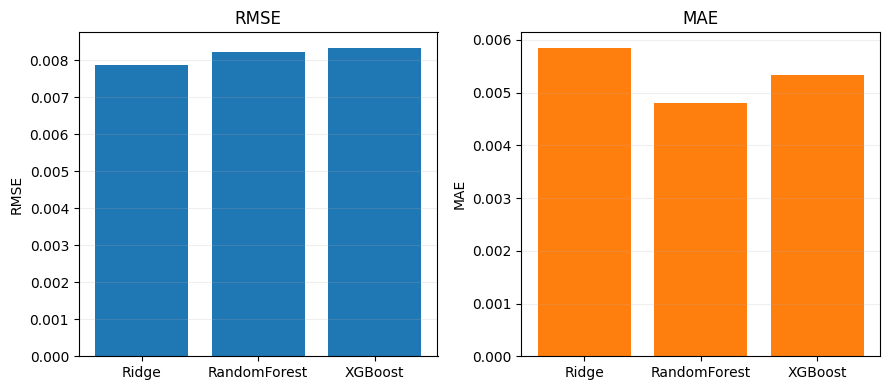

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
axes[0].bar(results_df["model"], results_df["RMSE"], color="#1f77b4")
axes[0].set_title("RMSE")
axes[0].set_ylabel("RMSE")
axes[0].grid(True, axis="y", alpha=0.2)

axes[1].bar(results_df["model"], results_df["MAE"], color="#ff7f0e")
axes[1].set_title("MAE")
axes[1].set_ylabel("MAE")
axes[1].grid(True, axis="y", alpha=0.2)

plt.tight_layout()